In [67]:
import pandas as pd

dataset = []

#reading the csv file
with open("monojet_Zp2000.0_DM_50.0_chan3.csv", mode='r') as f:
  for line in f:
    #separate each line based on semicolon
    temp = line.split(';')

    #now we have event ID; process ID; event weight; etc separated from our required data
    # extract each 4 momentum from each row and consider only those which have ID = 'j'
    #step 1: only read after the index = 5  to avoid reading event ID; process ID; etc. details
    #step 2: iterate through the row and extract each jet having ID = 'j'
    
    for jet in temp:
      jet = jet.split(',')
      if jet[0] == 'j':
        # we are not storing event ID here but can be done if required if we need it later for mapping purpose
        dataset.append([jet[1], jet[2], jet[3], jet[4]])

#changing the dataset from list to Pandas DataFrame
dataset = pd.DataFrame(dataset, columns=['e', 'pt', 'eta', 'phi'])

In [68]:
#viewing the top of the dataset
dataset.head()

,e,pt,eta,phi
0,258722,243675,0.328962,2.25014
1,520092,108590,-2.2473,-1.85679
2,383024,88405.6,2.14516,-1.95635
3,39507.6,35365.1,0.47046,-1.16445
4,225430,26878.2,-2.81608,-2.25938


In [69]:
#sanity check for datatype of the columns
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22661 entries, 0 to 22660
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   e       22661 non-null  object
 1   pt      22661 non-null  object
 2   eta     22661 non-null  object
 3   phi     22661 non-null  object
dtypes: object(4)
memory usage: 708.3+ KB


In [70]:
#converting data types of columns from object to numeric
dataset = dataset.apply(pd.to_numeric)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22661 entries, 0 to 22660
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   e       22661 non-null  float64
 1   pt      22661 non-null  float64
 2   eta     22661 non-null  float64
 3   phi     22661 non-null  float64
dtypes: float64(4)
memory usage: 708.3 KB


In [71]:
# normalizing/scaling our data
import math
dataset['e'] = dataset['e'].apply(math.log10)
dataset['pt'] = dataset['pt'].apply(math.log10)
dataset['eta'] = dataset['eta']/5.0
dataset['phi'] = dataset['phi']/3.0

In [73]:
#creating train and test data separately to test our model performance later
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.33, random_state=42)
print("Train dataset : ", train.shape)
print("Test dataset : ", test.shape)

Train dataset :  (15182, 4)
Test dataset :  (7479, 4)


Now we plot the data using the matplotlib library. The units reflect the normalization, but it's the shape that we care about.



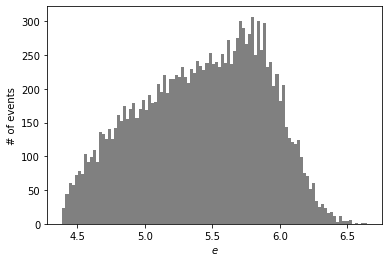

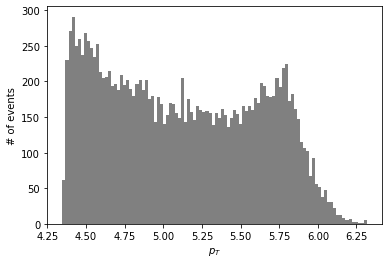

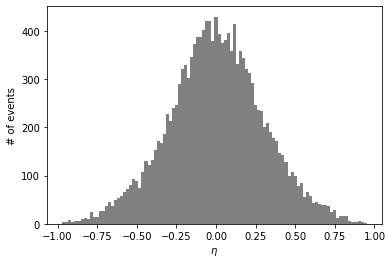

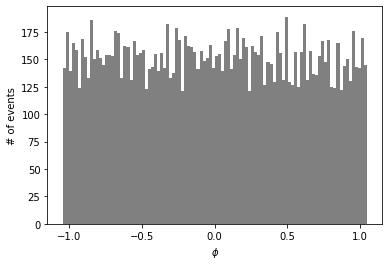

In [74]:
import matplotlib.pyplot as plt

#unit_list = ['[log(GeV)]', '[rad/3]', '[rad/3]', '[log(GeV)]']
variable_list = [ r'$e$', r'$p_T$', r'$\eta$', r'$\phi$']

branches=["e","pt","eta","phi"]

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk])
    plt.ylabel('# of events')
    #plt.savefig("fourmomentum_"+branches[kk],dpi=300)
    plt.show()

### Setting up the network¶
#### Preparing the data
Adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later)

In [ ]:
!pip3 install fastai

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

train_x = train
test_x = test
train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

We now set things up to load the data, and we use a batch size that was optimized by previous students...note also that this is fastai v2, migration thanks to Jessica Lastow.



In [77]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

### Preparing the network
Here we have an example network. Details aren't too important, as long as they match what was already trained for us...in this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4.

In [78]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize.


In [79]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)
#was: learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

using Alternative 2 since we don't have access to pretrained network
### Alternative 2: Training a new network

Instead of using a pre-trained network, an alternative is to train a new network and use that instead.

First, we want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:

- one tenth of the minimum before the divergence
- when the slope is the steepest

Learning rate with the minimum loss: 0.014454397559165954
Learning rate with the steepest gradient: 0.002511886414140463


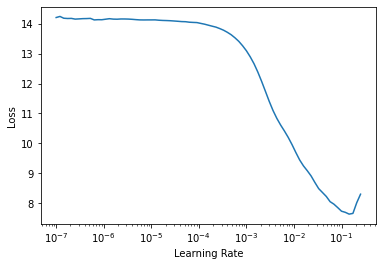

In [80]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

Now we want to run the training!

User-chosen variables:

- n_epoch: The number of epochs, i.e how many times the to run through all of the training data once (i.e the 1266046 entries, see cell 2)
- lr: The learning rate. Either choose lr_min, lr_steep from above or set your own.

In [81]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=100, lr_max=lr_min)

end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 2.071936845779419, 0.28380513191223145, '00:00']
[0, 2.071936845779419, 0.28380513191223145, '00:00']
[1, 0.6787644624710083, 0.23716697096824646, '00:01']
[1, 0.6787644624710083, 0.23716697096824646, '00:01']
[2, 0.3548169732093811, 0.22783078253269196, '00:01']
[2, 0.3548169732093811, 0.22783078253269196, '00:01']
[3, 0.26535603404045105, 0.22696618735790253, '00:01']
[3, 0.26535603404045105, 0.22696618735790253, '00:01']
[4, 0.23923711478710175, 0.22931702435016632, '00:01']
[4, 0.23923711478710175, 0.22931702435016632, '00:01']
[5, 0.23234952986240387, 0.22660580277442932, '00:01']
[5, 0.23234952986240387, 0.22660580277442932, '00:01']
[6, 0.1918395459651947, 0.1375131458044052, '00:01']
[6, 0.1918395459651947, 0.1375131458044052, '00:01']
[7, 0.15141241252422333, 0.11567175388336182, '00:01']
[7, 0.15141241252422333, 0.11567175388336182, '00:01']
[8, 0.07934311032295227, 0.040720731019973755, '00:01']
[8, 0.07934311032295227, 0.040720731019973755, '00:01']
[9, 0.05385227128863

Then we plot the loss as a function of batches and epochs to check if we reach a plateau.



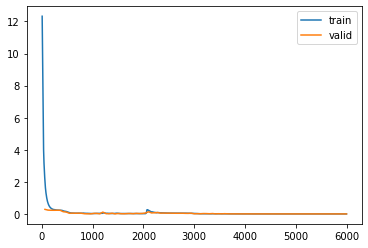

In [82]:
recorder.plot_loss()

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.



In [83]:
learn.validate()

(#1) [6.38772253296338e-05]

### Plotting the outputs of the network¶
Lazy-save of our output files (they'll also be on screen)


In [84]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# A function in case we want to un-normalize and get back to physical quantities...

def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    df['e'] = 10**df['e']
    #df['m'] = 10**df['m']
    df['pt'] = 10**(df['pt'])
    return df

# Make the histograms from the dataset...  

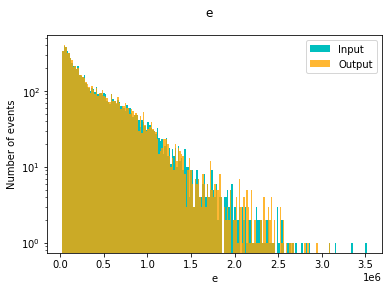

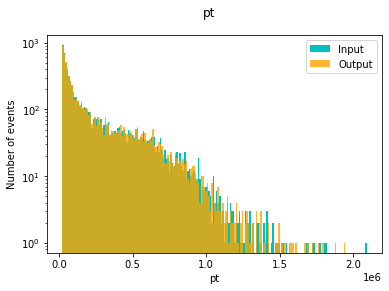

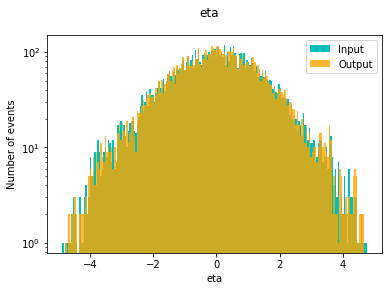

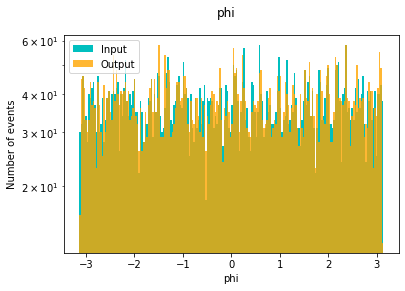

In [90]:
import numpy as np

plt.close('all')

#unit_list = ['[log(GeV)]', '[rad/3]', '[rad/3]', '[log(GeV)]']
variable_list = [ r'$e$', r'$p_T$', r'$\eta$', r'$\phi$']

line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = False # Option to save figure

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
#data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float).double()
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)    

alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'.png'))
    plt.legend()